Import modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import time

Mount Drive and unzip PTB-XL Database


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/Szakdoga/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19342_hr.dat  
  inflating: ptb-xl-a-large-publicly-availabl

Set device configuration

In [4]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Install wfdb

In [5]:
!pip install wfdb

     |████████████████████████████████| 137 kB 5.3 MB/s 
     |████████████████████████████████| 11.2 MB 37.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [7]:
BATCH_SIZE = 100 #4
sampling_rate=100
test_fold = 10
train_dim = 300 # we sample until 300 ms so each training data is a tensor with shape (1, 300)
channel_num = 9
error_func = 'conventional' # SWD, conventional

db_path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

Load training data

In [8]:
import wfdb
import ast
import pandas as pd

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# load and convert annotation data
Y = pd.read_csv(db_path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
raw_signal_data = load_raw_data(Y, sampling_rate, db_path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(db_path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [9]:
Data = raw_signal_data[np.where(Y.strat_fold != test_fold)]
#Data = raw_signal_data[np.where(Y. == 'NORM')]
annot = Y[Y.strat_fold != test_fold].diagnostic_superclass
#Data = Data[:, :train_dim, channel_num]
Data = Data[:19600, :train_dim, channel_num]
print(Data.shape)

(19600, 300)


In [10]:
tensor_x = torch.Tensor(Data)

train_dataset = torch.utils.data.TensorDataset(tensor_x)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(tensor_x.shape)

torch.Size([19600, 300])


In [11]:
#define generator network
class Generator(nn.Module):
  def __init__(self, gen_input_dim, gen_output_dim):  #gen_input_dim -> dimension of the noise
                                                      #gen_output_dim -> dimension of the output
    super(Generator, self).__init__()

    # size after 1D conv layer: (w + 2p - k) / s + 1
    # w: input size, k: kernel size, p: padding, s: stride

    # CNN -> noise dim = 100

    '''self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=0) #98
    self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, padding=0) #96
    self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, padding=0) #94
    self.conv4 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=0) #92
    self.conv5 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=0) #90
    self.conv6 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=0) #88
    self.fc1 = nn.Linear(64*88, 2048)
    self.fc2 = nn.Linear(2048, 1024)
    self.fc3 = nn.Linear(1024, 512)
    self.fc4 = nn.Linear(512, gen_output_dim)

  def forward(self, output):
    output = torch.unsqueeze(output, 1)
    output = F.leaky_relu(self.conv1(output), 0.01)
    output = F.leaky_relu(self.conv2(output), 0.01)
    output = F.leaky_relu(self.conv3(output), 0.01)
    output = F.leaky_relu(self.conv4(output), 0.01)
    output = F.leaky_relu(self.conv5(output), 0.01)
    output = F.leaky_relu(self.conv6(output), 0.01)
    output = output.view(-1, 64*88)
    output = F.leaky_relu(self.fc1(output), 0.01)
    output = F.leaky_relu(self.fc2(output), 0.01)
    output = F.leaky_relu(self.fc3(output), 0.01)

    return self.fc4(output)'''

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=1) #98
    self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, padding=1) #96
    self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, padding=1) #94
    self.conv4 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=1) #92
    self.conv5 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1) #90
    self.conv6 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1) #10
    self.fc1 = nn.Linear(64*100, 2048)
    self.fc2 = nn.Linear(2048, 1024)
    self.fc3 = nn.Linear(1024, 512)
    self.fc4 = nn.Linear(512, gen_output_dim)

  def forward(self, output):
    output = torch.unsqueeze(output, 1)
    output = F.leaky_relu(self.conv1(output), 0.01)
    output = F.leaky_relu(self.conv2(output), 0.01)
    output = F.leaky_relu(self.conv3(output), 0.01)
    output = F.leaky_relu(self.conv4(output), 0.01)
    output = F.leaky_relu(self.conv5(output), 0.01)
    output = F.leaky_relu(self.conv6(output), 0.01)
    output = output.view(-1, 64*100)
    output = F.leaky_relu(self.fc1(output), 0.01)
    output = F.leaky_relu(self.fc2(output), 0.01)
    output = F.leaky_relu(self.fc3(output), 0.01)

    return self.fc4(output)


#define discriminator network
class Discriminator(nn.Module):
  def __init__(self, disc_input_dim):  #disc_input_dim -> dimension of a sample (1*300)
                                       #output dimension -> probability of a sample being real
    super(Discriminator, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=0)#298
    self.bn1 = nn.BatchNorm1d(2)
    self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=3, padding=0)#296
    self.bn2 = nn.BatchNorm1d(4)
    self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, padding=0)#294
    self.bn3 = nn.BatchNorm1d(8)
    self.conv4 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=0)#292
    self.bn4 = nn.BatchNorm1d(16)
    self.conv5 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=0)#290
    self.bn5 = nn.BatchNorm1d(32)
    self.conv6 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=0)#288
    self.fc1 = nn.Linear(64*288, 2048) #64*288
    self.fc2 = nn.Linear(2048, 1024)
    self.fc3 = nn.Linear(1024, 512)
    self.fc4 = nn.Linear(512, 256)
    self.fc5 = nn.Linear(256, 1)

  
  def forward(self, output):
    output = torch.unsqueeze(output, 1)
    '''output = F.leaky_relu(self.bn1(self.conv1(output)), 0.2)
    output = F.leaky_relu(self.bn2(self.conv2(output)), 0.2)
    output = F.leaky_relu(self.bn3(self.conv3(output)), 0.2)
    output = F.leaky_relu(self.bn4(self.conv4(output)), 0.2)
    output = F.leaky_relu(self.bn5(self.conv5(output)), 0.2)'''
    output = F.leaky_relu(self.conv1(output), 0.2)
    output = F.leaky_relu(self.conv2(output), 0.2)
    output = F.leaky_relu(self.conv3(output), 0.2)
    output = F.leaky_relu(self.conv4(output), 0.2)
    output = F.leaky_relu(self.conv5(output), 0.2)
    output = F.leaky_relu(self.conv6(output), 0.2)
    output = output.view(-1, 64*288) #276 (k=7), 288 (k=3), 64*288
    output = F.leaky_relu(self.fc1(output), 0.2)
    output = F.dropout(output, p=0.3)
    output = F.leaky_relu(self.fc2(output), 0.2)
    output = F.dropout(output, p=0.3)
    output = F.leaky_relu(self.fc3(output), 0.2)
    output = F.dropout(output, p=0.3)
    output = F.leaky_relu(self.fc4(output), 0.2)
    output = F.dropout(output, p=0.3)

    return torch.sigmoid(self.fc5(output))



In [12]:
# source: https://github.com/VinAIResearch/DSW
def sliced_wasserstein_dist(real_shape, fake_shape, device, num_projections=1000, p=2):
  dim = fake_shape.size(1)
  projections = torch.randn((num_projections, dim))
  projections = projections / torch.sqrt(torch.sum(projections ** 2, dim=1, keepdim=True))
  projections = projections.to(device)
  first_projections = real_shape.matmul(projections.transpose(0, 1))
  second_projections = fake_shape.matmul(projections.transpose(0, 1))
  wasserstein_distance = torch.abs(
        (
            torch.sort(first_projections.transpose(0, 1), dim=1)[0]
            - torch.sort(second_projections.transpose(0, 1), dim=1)[0]
        )
    )
  wasserstein_distance = torch.pow(torch.sum(torch.pow(wasserstein_distance, p), dim=1), 1.0 / p)
  return torch.pow(torch.pow(wasserstein_distance, p).mean(), 1.0 / p)

# source: https://github.com/VinAIResearch/DSW
def train_SWD(discriminator, generator, optimizer, minibatch, device, p=2):
  x_real = minibatch.view(-1, train_dim)  #move samples to the right dimension
  y_real = torch.ones(BATCH_SIZE, 1)  #create a label tensor for the real training samples (1 -> real samples)
  criterion = nn.BCELoss()
  x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device)) #move variables to GPU
  noise = Variable(torch.randn(BATCH_SIZE, noise_dim).to(device)) #create random noise for Generator
  x_fake = generator(noise)

  D_out_real = discriminator(x_real.detach())
  D_real_loss = criterion(D_out_real, y_real)
  optimizer.zero_grad()
  D_real_loss.backward()
  optimizer.step()

  #train Discriminator on fake samples
  y_fake = torch.zeros(BATCH_SIZE, 1)
  x_fake, y_fake = Variable(x_fake.to(device)), Variable(y_fake.to(device))

  D_out_fake = discriminator(x_fake.detach())
  D_fake_loss = criterion(D_out_fake, y_fake)

  optimizer.zero_grad()
  D_fake_loss.backward()
  optimizer.step()

  data = discriminator(x_real)
  data_fake = discriminator(x_fake)

  _swd = sliced_wasserstein_dist(data, data_fake, device)

  return _swd


def D_train_conventional(x): #x -> batch size of input image data
  D.zero_grad()

  #train Discriminator on real samples
  x_real = x.view(-1, train_dim)  #move samples to the right dimension
  y_real = torch.ones(BATCH_SIZE, 1)  #create a label tensor for the real training samples (1 -> real samples)
  x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device)) #move variables to GPU

  D_out_real = D(x_real)
  D_real_loss = criterion(D_out_real, y_real)

  #train Discriminator on fake samples
  noise = Variable(torch.rand(BATCH_SIZE, noise_dim).to(device)) #create random noise for Generator
  x_fake = G(noise)
  #x_fake = G(torch.cat((noise, x_real)))
  y_fake = torch.zeros(BATCH_SIZE, 1)
  x_fake, y_fake = Variable(x_fake.to(device)), Variable(y_fake.to(device))

  D_out_fake = D(x_fake)
  D_fake_loss = criterion(D_out_fake, y_fake)

  #calculate overall loss + backprop
  D_loss = D_real_loss + D_fake_loss
  D_loss.backward()
  D_optim.step()

  return D_loss.data.item()

def G_train_conventional(x):
  G.zero_grad()
  noise = Variable(torch.rand(BATCH_SIZE, noise_dim).to(device))
  y = torch.ones(BATCH_SIZE, 1)
  y = Variable(y.to(device))

  x = G(noise)
  D_out = D(x)

  G_loss = criterion(D_out, y)
  G_loss.backward()
  G_optim.step()

  return G_loss.data.item()

In [13]:
noise_dim = 100 #dimension of the noise10
G = Generator(gen_input_dim=noise_dim, gen_output_dim=train_dim).to(device)
D = Discriminator(disc_input_dim=train_dim).to(device)

#loss function -> BCE loss
if error_func == 'conventional':
  criterion = nn.BCELoss()


#optimizer
lr = 0.0005  #learning rate 0.0002
G_optim = optim.Adam(G.parameters(), lr=lr)
D_optim = optim.Adam(D.parameters(), lr=lr)

numOfEpochs = 5  #number of epochs

In [14]:
start_time = time.time()
for epoch in range(1, numOfEpochs + 1):
  t_loss, D_losses, G_losses = [], [], []
  total_loss = 0.0
  for batch_idx, x in enumerate(train_loader):
    x = x[0]
    #print(x.shape)
    if error_func == 'conventional':
      D_losses.append(D_train_conventional(x))
      G_losses.append(G_train_conventional(x))
    elif error_func == 'SWD':
      loss = train_SWD(D, G, D_optim, x, device)
      D_optim.zero_grad()
      total_loss += loss.item()
      t_loss.append(loss.data.item())
      loss.backward()
      D_optim.step()
    else:
      print(f'There is no error function named {error_func}. Possible values: conventional, SWD')
      break

  if error_func == 'conventional':
    print(f'[{epoch}/{numOfEpochs}] Generator loss: {torch.mean(torch.FloatTensor(D_losses))}, Discriminator loss: {torch.mean(torch.FloatTensor(G_losses))}')
  else:
    #print(f'[{epoch}/{numOfEpochs}] Loss: {torch.mean(torch.FloatTensor(total_loss))}')
    print(f"[{epoch}/{numOfEpochs}] Loss: {total_loss}")

training_time = time.time() - start_time

[1/5] Generator loss: 1.4177582263946533, Discriminator loss: 0.8059569597244263
[2/5] Generator loss: 1.4204723834991455, Discriminator loss: 0.9282012581825256
[3/5] Generator loss: 1.4093225002288818, Discriminator loss: 0.7225582599639893
[4/5] Generator loss: 1.3843201398849487, Discriminator loss: 0.7257959842681885
[5/5] Generator loss: 1.3876173496246338, Discriminator loss: 0.6889727115631104


In [15]:
print(training_time)
with torch.no_grad():
    test_z = Variable(torch.randn(BATCH_SIZE, noise_dim).to(device))
    generated = G(test_z)
    generated=generated.cpu().detach().numpy()

132.82597708702087


In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.2.2

In [17]:
print(generated.shape)

(100, 300)


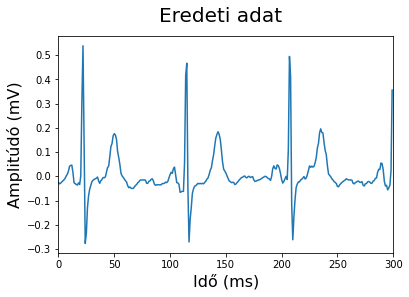

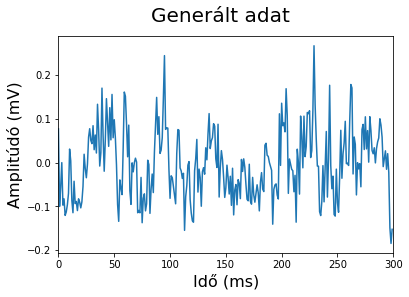

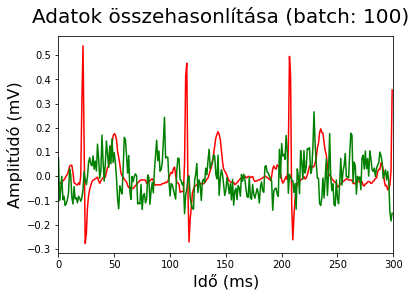

In [18]:
f, ax = plt.subplots(1)
f.suptitle(f'Eredeti adat', fontsize=20)
ax.plot(Data[0, :])
ax.set_xlim(0, 300)
ax.set_xlabel('Idő (ms)', fontsize=16)
ax.set_ylabel('Amplitúdó (mV)', fontsize=16)

f, ax = plt.subplots(1)
f.suptitle(f'Generált adat', fontsize=20)
ax.plot(generated[0, :])
ax.set_xlim(0, 300)
ax.set_xlabel('Idő (ms)', fontsize=16)
ax.set_ylabel('Amplitúdó (mV)', fontsize=16)

f, ax = plt.subplots(1)
f.suptitle(f'Adatok összehasonlítása (batch: {BATCH_SIZE})', fontsize=20)
ax.plot(Data[0, :], label='eredeti', color='r')
ax.plot(generated[0, :], label='generált', color='g')
ax.set_xlim(0, 300)
ax.set_xlabel('Idő (ms)', fontsize=16)
ax.set_ylabel('Amplitúdó (mV)', fontsize=16)


plt.show()

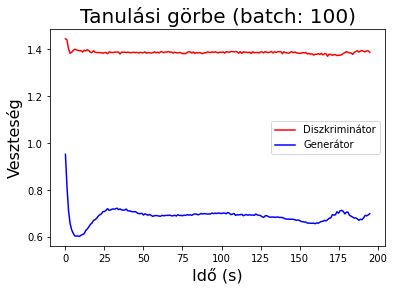

In [19]:
#plot loss curve
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

plt.title(f'Tanulási görbe (batch: {BATCH_SIZE})', fontsize=20)
plt.xlabel('Idő (s)', fontsize=16)
plt.ylabel('Veszteség', fontsize=16)
if error_func == 'conventional':
  plt.plot(D_losses, 'r', label='Diszkriminátor')
  plt.plot(G_losses, 'b', label='Generátor')
elif error_func == 'SWD':
  plt.plot(t_loss, 'r', label='SWD loss')
else:
  print(f'There is no error function defined named "{error_func}"')
plt.legend(loc='best')
plt.show()